In [2]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities
from snowflake.snowpark.functions import col

import getpass
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
accountname = 'lo67467.ap-southeast-1'

In [4]:
username = getpass.getpass()    # SNOWFLAKE-USERNAME

In [5]:
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

In [6]:
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import snowflake.connector

conn = snowflake.connector.connect(
    user=username,
    password=password,
    account=accountname,
    warehouse='COMPUTE_WH',
    #warehouse='HOL_WH',
    #database='FROSTBYTE_TASTY_BYTES',
    #schema='ANALYTICS'
)
#connection
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    #"database": "FROSTBYTE_TASTY_BYTES",
    "warehouse": 'COMPUTE_WH'
    #"warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()


In [46]:
X_final_scaled = pd.read_csv('x_final_scaled.csv')

In [8]:
#X_final_scaled

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,Profit,LAT,LONG,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,68,7,8,6,10,0,10027.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
1,68,7,9,6,10,0,17477.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
2,68,7,10,6,10,0,13992.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
3,68,7,11,6,10,0,17616.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
4,68,7,12,6,10,0,15415.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540196,17,4,9,3,8,0,5711.0,39.750495,-104.932312,5115,...,0,1,0,0,0,0,0,1,0,0
540197,17,4,10,3,8,0,3741.0,39.750495,-104.932312,5115,...,0,1,0,0,0,0,0,1,0,0
540198,17,4,11,3,8,0,2786.0,39.750495,-104.932312,5115,...,0,1,0,0,0,0,0,1,0,0
540199,17,4,12,3,8,0,4843.0,39.750495,-104.932312,5115,...,0,1,0,0,0,0,0,1,0,0


In [330]:
session.use_schema("ANALYTICS")
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()
#X_final_scaled = X_final_scaled.iloc[:, [0,1, 2, 3,4,5,6,7,8,9,10,11,12,28,29,30,31,32,33,34,35,36,37]] 
#X_final_scaled = X_final_scaled.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,20,21,22,24,27,28,29,30,31,32,33,34,35,36,37]] 

In [47]:
#X_final_scaled.drop('LAT', axis=1, inplace=True)
#X_final_scaled.drop('DOW', axis=1, inplace=True)
X_final_scaled.drop(['PUBLIC_HOLIDAY', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED','MENU_TYPE_BBQ_ENCODED','MENU_TYPE_SANDWICHES_ENCODED','MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_INDIAN_ENCODED'], axis=1, inplace=True)

#X_final_scaled.drop('DAY', axis=1, inplace=True)
#X_final_scaled.drop('SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', axis=1, inplace=True)
#X_final_scaled.drop('SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', axis=1, inplace=True)

In [41]:
X_final_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540201 entries, 0 to 540200
Data columns (total 28 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TRUCK_ID                                  540201 non-null  int64  
 1   MONTH                                     540201 non-null  int64  
 2   HOUR                                      540201 non-null  int64  
 3   DOW                                       540201 non-null  int64  
 4   DAY                                       540201 non-null  int64  
 5   Profit                                    540201 non-null  float64
 6   LAT                                       540201 non-null  float64
 7   LONG                                      540201 non-null  float64
 8   LOCATION_ID                               540201 non-null  int64  
 9   SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE        540201 non-null  float64
 10  SUM_PREV_YEAR_MONTH_

The final dataset has 37 columns. This section covers feature selection, further data wrangling, machine learning modelling, and hyperparameter tuning. 

The first part covers feature selection. It is the process of selecting a subset of the most relevant features from the originally larger set of features in order to improve model performance, reduce overfitting, and reduce training time. From the code and graphical representation below, it is observed that features like MONTH, DOW, DAY, PUBLIC_HOLIDAY, MENU_TYPE_GYROS_ENCODED,MENU_TYPE_CREPES_ENCODED, MENU_TYPE_BBQ_ENCODED, MENU_TYPE_SANDWICHES_ENCODED, MENU_TYPE_Mac & Cheese_encoded, MENU_TYPE_POUTINE_ENCODED, MENU_TYPE_ETHIOPIAN_ENCODED, MENU_TYPE_CHINESE_ENCODED, MENU_TYPE_INDIAN_ENCODED have a low feature importance score of less than 0.01. This feature selection method uses mutual information regression with scikit-learn's SelectKBest function. The features mentioned above with low feature importance scores have a weak relationship with the target variable. Features like date time columns, cannot be removed although they have low feature importance scores as they are needed for our routing algorithm.


After that, we perform data transformation, manipulating the data to prepare it for machine learning modelling. Winsorization was performed on the 'Profit' column, to reduce the impact of extreme values. This aims to make statistical estimates more robust to outliers while still retainnig the information contained in the original data. Doing so significantly reduced the mean squared error by 300. Columns SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE and SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE also has outliers observed, hence it is also winsorized. 


Following that is the machine learning modelling. Regression models including XG-Boost, Ada Boost, Random Forest and Light GBM were experimented on. Among the stated models, the XG-Boost had the best baseline model performance, followed by LightGBM. Hence we will work more with these two models in the next segment, Hyperparameter tuning. The metrics used are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE) and r squared (R2). The performance of the best two baseline models are shown below: 

#### XG-BOOST BASELINE
Train MSE is:  1900977.7969064126
Test MSE is:  2024851.7489593595

Train RMSE is:  1378.759513804497
Test RMSE is:  1422.972856016361

Train MAE is:  920.3543073818786
Test MAE is:  942.519100817783

Train R2 is:  0.897015311234036
Test R2 is:  0.890844141403374

#### LIGHT GBM BASELINE
Train MSE is:  2023885.636160862
Test MSE is:  2045224.874378391

Train RMSE is:  1422.6333456519505
Test RMSE is:  1430.113587928732

Train MAE is:  946.343699332115
Test MAE is:  946.2123571060355

Train R2 is:  0.8892868452809964
Test R2 is:  0.8886959896079126



For hyperparameter tuning, a few methods were used, GridSearch, RandomSearch, and Bayesian Optimisation. The Bayesian Optimisation method is very helpful for optimizing functions that are expensive to evaluate, where each evaluation of the function requires expensive or time-consuming calculation. It functions by creating a surrogate function, a probabilistic model of the objective function, which is then effectively searched with an acquisition function before candidate samples are chosen for evaluation on the actual objective function. Using this method derived the best parameters for the XG-Boost model, which is shown below:

xgb = XGBRegressor(objective="reg:squarederror", learning_rate=0.01523, max_depth=9, colsample_bytree=0.578, n_estimators=641, subsample=0.854)


Feature 1: 0.779276
Feature 2: 0.001307
Feature 3: 0.111625
Feature 4: 0.003169
Feature 5: 0.000921
Feature 6: 0.001238
Feature 7: 0.578047
Feature 8: 0.466503
Feature 9: 0.433097
Feature 10: 0.746928
Feature 11: 0.365405
Feature 12: 0.011273
Feature 13: 0.005992
Feature 14: 0.003293
Feature 15: 0.005890
Feature 16: 0.004828
Feature 17: 0.002003
Feature 18: 0.007686
Feature 19: 0.003432
Feature 20: 0.038470
Feature 21: 0.016497
Feature 22: 0.013232
Feature 23: 0.005620
Feature 24: 0.049781
Feature 25: 0.011833
Feature 26: 0.009013
Feature 27: 0.026172
Feature 28: 0.051941
Feature 29: 0.075530
Feature 30: 0.258049
Feature 31: 0.353675
Feature 32: 0.040336
Feature 33: 0.350898
Feature 34: 0.039762
Feature 35: 0.076102
Feature 36: 0.054140
Feature 37: 0.257216


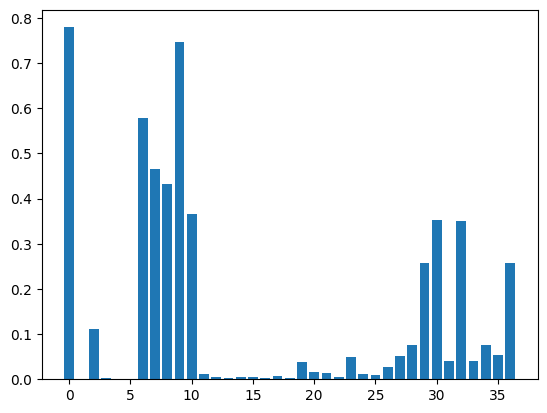

In [238]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt 

# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=mutual_info_regression, k=17)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i+1, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [22]:
X_final_scaled.corr()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,Profit,LAT,LONG,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
TRUCK_ID,1.000000,0.007781,0.005988,0.000498,-0.002358,-0.002959,0.690489,0.302193,0.776616,0.181107,...,-0.025135,-0.419328,-0.626146,0.714244,0.313530,0.714244,0.313530,-0.419328,-0.025135,-0.626146
MONTH,0.007781,1.000000,0.000997,0.002124,0.009020,0.067205,0.004032,0.015049,0.000489,0.001608,...,0.010976,-0.004435,-0.009207,-0.009733,0.011374,-0.009733,0.011374,-0.004435,0.010976,-0.009207
HOUR,0.005988,0.000997,1.000000,0.001847,-0.000621,-0.000637,0.051377,0.004231,0.004370,0.000099,...,0.001450,0.002564,-0.009109,0.002283,0.001646,0.002283,0.001646,0.002564,0.001450,-0.009109
DOW,0.000498,0.002124,0.001847,1.000000,-0.008413,-0.015868,0.019797,0.001520,-0.000069,0.004987,...,0.001189,-0.001483,-0.000054,-0.001089,0.001485,-0.001089,0.001485,-0.001483,0.001189,-0.000054
DAY,-0.002358,0.009020,-0.000621,-0.008413,1.000000,0.028256,-0.000648,-0.002106,-0.001921,-0.000053,...,-0.000757,-0.001303,0.004220,0.000129,-0.001746,0.000129,-0.001746,-0.001303,-0.000757,0.004220
PUBLIC_HOLIDAY,-0.002959,0.067205,-0.000637,-0.015868,0.028256,1.000000,-0.003944,0.000489,-0.004210,-0.008233,...,0.002042,0.002583,0.000867,-0.002343,-0.003275,-0.002343,-0.003275,0.002583,0.002042,0.000867
Profit,0.690489,0.004032,0.051377,0.019797,-0.000648,-0.003944,1.000000,0.002258,0.534167,0.056169,...,-0.150789,-0.175780,-0.384122,0.801824,-0.119630,0.801824,-0.119630,-0.175780,-0.150789,-0.384122
LAT,0.302193,0.015049,0.004231,0.001520,-0.002106,0.000489,0.002258,1.000000,-0.191859,0.139231,...,0.904798,-0.345449,-0.534040,-0.164007,0.072421,-0.164007,0.072421,-0.345449,0.904798,-0.534040
LONG,0.776616,0.000489,0.004370,-0.000069,-0.001921,-0.004210,0.534167,-0.191859,1.000000,0.207362,...,-0.571493,-0.163169,-0.454354,0.554839,0.614431,0.554839,0.614431,-0.163169,-0.571493,-0.454354
LOCATION_ID,0.181107,0.001608,0.000099,0.004987,-0.000053,-0.008233,0.056169,0.139231,0.207362,1.000000,...,0.002716,0.095444,-0.326638,-0.024827,0.213731,-0.024827,0.213731,0.095444,0.002716,-0.326638


<AxesSubplot:ylabel='SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'>

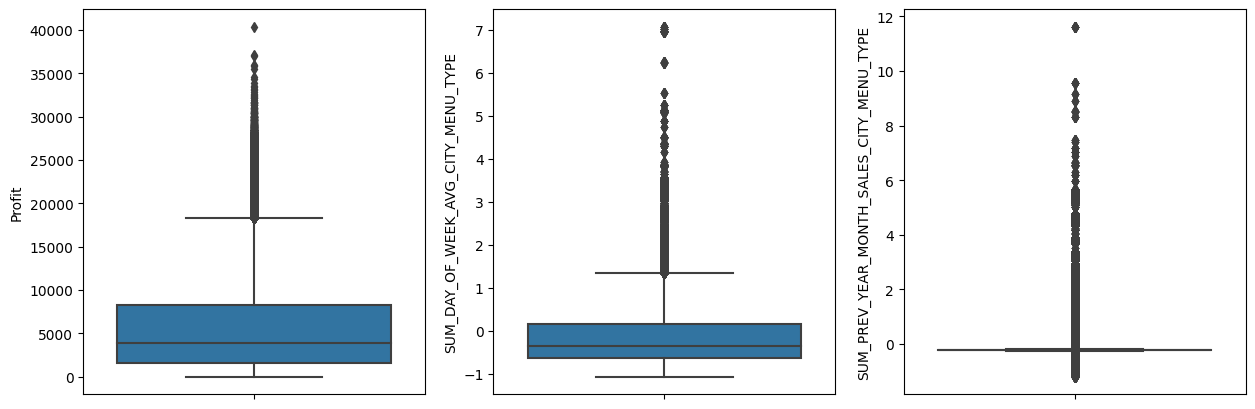

In [12]:
#check for outliers
import numpy as np
import seaborn as sns

fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

sns.boxplot(y='Profit', data=X_final_scaled, ax=axs[0])
sns.boxplot(y='SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', data=X_final_scaled, ax=axs[1])
sns.boxplot(y='SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', data=X_final_scaled, ax=axs[2])

In [13]:
#X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'] = X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].apply(np.sqrt)
#X_final_scaled['Profit'] = X_final_scaled['Profit'].apply(np.sqrt)
#X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'] = X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].apply(np.sqrt)


In [48]:
def winsorise(df, variable, upper_limit, lower_limit):
    return np.where(df[variable] > upper_limit, upper_limit, 
                    np.where(df[variable] < lower_limit, lower_limit, df[variable]))

X_final_scaled['Profit']= winsorise(X_final_scaled, 'Profit', X_final_scaled['Profit'].quantile(0.85), X_final_scaled['Profit'].quantile(0))
X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE']= winsorise(X_final_scaled, 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].quantile(0.85), X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].quantile(0))
X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE']= winsorise(X_final_scaled, 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].quantile(0.8), X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].quantile(0.5))

TypeError: 'AxesSubplot' object is not subscriptable

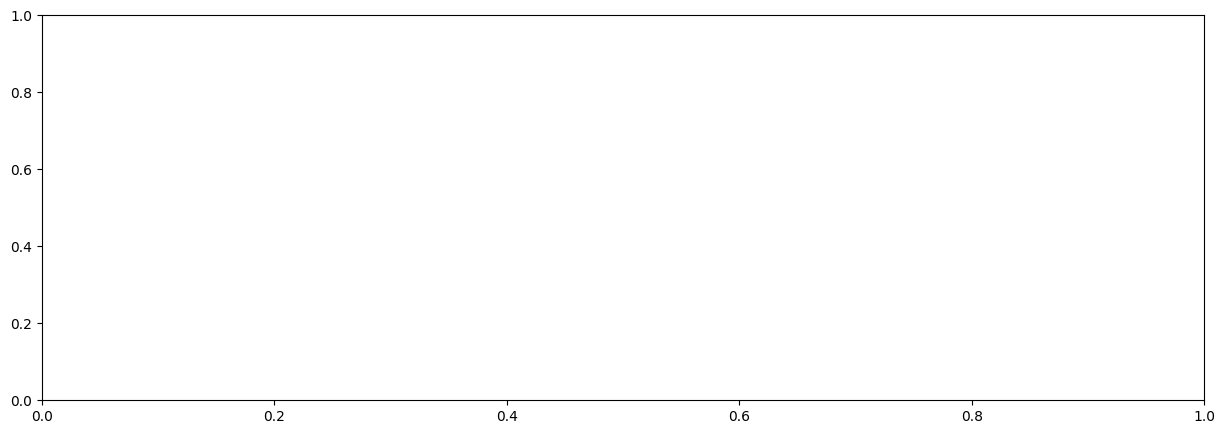

In [43]:
#check for outliers
fig, axs = plt.subplots(figsize=(15, 5), ncols=1)

sns.boxplot(y='Profit', data=X_final_scaled, ax=axs[0])
#sns.boxplot(y='SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', data=X_final_scaled, ax=axs[1])
#sns.boxplot(y='SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', data=X_final_scaled, ax=axs[2])

## Train Test Split

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Split the dataset into features (X) and target (y)
X = X_final_scaled.drop("Profit",axis=1)
y = X_final_scaled["Profit"]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

LightGBM

In [336]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(lgbm.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(lgbm.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(lgbm.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(lgbm.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(lgbm.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(lgbm.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(lgbm.predict(X_train), y_train))
print('Test R2 is: ', r2_score(lgbm.predict(X_test), y_test))

Train MSE is:  2023885.636160862
Test MSE is:  2045224.874378391

Train RMSE is:  1422.6333456519505
Test RMSE is:  1430.113587928732

Train MAE is:  946.343699332115
Test MAE is:  946.2123571060355

Train R2 is:  0.8892868452809964
Test R2 is:  0.8886959896079126


XGBOOST

In [337]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [338]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

Train MSE is:  1900977.7969064126
Test MSE is:  2024851.7489593595

Train RMSE is:  1378.759513804497
Test RMSE is:  1422.972856016361

Train MAE is:  920.3543073818786
Test MAE is:  942.519100817783

Train R2 is:  0.897015311234036
Test R2 is:  0.890844141403374


In [400]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective="reg:squarederror", learning_rate=0.3, max_depth=7, colsample_bytree=0.6)
xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

c:\Users\ayrto\anaconda3\envs\snowpark_0110\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5125.69205
[1]	validation_0-rmse:3763.79522
[2]	validation_0-rmse:2881.99175
[3]	validation_0-rmse:2356.09254
[4]	validation_0-rmse:1985.56062
[5]	validation_0-rmse:1771.40778
[6]	validation_0-rmse:1658.97082
[7]	validation_0-rmse:1600.32165
[8]	validation_0-rmse:1569.11319
[9]	validation_0-rmse:1551.85895
[10]	validation_0-rmse:1504.71194
[11]	validation_0-rmse:1479.49324
[12]	validation_0-rmse:1465.38548
[13]	validation_0-rmse:1462.90075
[14]	validation_0-rmse:1460.36933
[15]	validation_0-rmse:1454.52890
[16]	validation_0-rmse:1447.54746
[17]	validation_0-rmse:1443.72172
[18]	validation_0-rmse:1440.16707
[19]	validation_0-rmse:1438.73641
[20]	validation_0-rmse:1437.94035
[21]	validation_0-rmse:1437.35753
[22]	validation_0-rmse:1435.90874
[23]	validation_0-rmse:1434.23013
[24]	validation_0-rmse:1432.48907
[25]	validation_0-rmse:1432.04677
[26]	validation_0-rmse:1431.35496
[27]	validation_0-rmse:1430.74825
[28]	validation_0-rmse:1430.21254
[29]	validation_0-rmse:1

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameter space to search
param_distributions = {
    'learning_rate': np.logspace(-3, 0, 100),
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(1, 10),
    'num_leaves': range(10, 100),
    'min_child_samples': range(1, 20),
    'reg_alpha': np.logspace(-5, 1, 100),
    'reg_lambda': np.logspace(-5, 1, 100),
}

# Create an instance of the LightGBM regressor
lgbm = LGBMRegressor()

# Create an instance of the RandomizedSearchCV object
random_search = RandomizedSearchCV(lgbm, param_distributions, n_iter=100, cv=5, n_jobs=-1)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print('Best hyperparameters: ', random_search.best_params_)
print('MSE: ', random_search.best_score_)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# Define the function to optimize
def xgb_cv(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    estimator = XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    # Calculate cross-validation score
    scores = cross_val_score(estimator, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

# Define the parameter bounds to search over
pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (2, 10),
    'learning_rate': (0.01, 0.1),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

# Create the optimizer object and run the optimization
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Get the best hyperparameters and train the model
best_params = optimizer.max['params']
model = XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(model.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(model.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(model.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(model.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(model.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(model.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(model.predict(X_train), y_train))
print('Test R2 is: ', r2_score(model.predict(X_test), y_test))

RANDOM FOREST

In [341]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

Train MSE is:  308511.251351777
Test MSE is:  2180047.9855692377

Train RMSE is:  555.4378915340374
Test RMSE is:  1476.4985558981214

Train MAE is:  360.886337677307
Test MAE is:  966.6809363719457

Train R2 is:  0.9839401365602465
Test R2 is:  0.8824003036095197


In [407]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor(min_samples_leaf=8)
rf.fit(X_train,y_train)

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

Train MSE is:  994560.2993626765
Test MSE is:  2129701.5261698705

Train RMSE is:  997.2764407939638
Test RMSE is:  1459.3496929008725

Train MAE is:  641.0596584808596
Test MAE is:  953.4123392937148

Train R2 is:  0.9466728757765563
Test R2 is:  0.8851861220657514


In [402]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf_model = RandomForestRegressor()

# Train the model with early stopping
best_val_error = float("inf")
best_rf_model = None
val_errors = []
for n_estimators in range(1, 100):
    rf_model.set_params(n_estimators=n_estimators)
    rf_model.fit(X_train, y_train)
    val_error = mean_squared_error(rf_model.predict(X_test), y_test)
    val_errors.append(val_error)
    if val_error < best_val_error:
        best_val_error = val_error
        best_rf_model = rf_model
    else:
        # If validation error doesn't improve for 5 iterations, stop training
        if len(val_errors) > 5 and val_errors[-5] >= val_error:
            break


print('Train MSE is: ', mean_squared_error(best_rf_model.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(best_rf_model.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(best_rf_model.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(best_rf_model.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(best_rf_model.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(best_rf_model.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(best_rf_model.predict(X_train), y_train))
print('Test R2 is: ', r2_score(best_rf_model.predict(X_test), y_test))

Train MSE is:  391062.7210088997
Test MSE is:  2325555.407411031

Train RMSE is:  625.3500787630074
Test RMSE is:  1524.9771825870152

Train MAE is:  386.2220393243776
Test MAE is:  995.5111005450261

Train R2 is:  0.9797372793799106
Test R2 is:  0.8754394983936021


In [403]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor(n_estimators=13)
rf.fit(X_train,y_train)

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

RandomForestRegressor(n_estimators=13)

In [ ]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

In [25]:
rf = RandomForestRegressor()

param_grid = {"n_estimators"      : [10,30,50, 100, 200],
              'ccp_alpha': [0.0, 0.1, 0.2],
              'criterion': ['mse', 'absolute_error'],
#             "max_features"      : ["auto", "sqrt", "log2"],
#              "min_samples_leaf" : [1, 5, 10],
#             "min_samples_split" : [2, 4, 10, 12, 16], 
#              "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90],
              'max_depth' : [5, 25, 125, 525, 1225]
             }

gs = GridSearchCV(rf, param_grid=param_grid, scoring='r2', cv= 3, n_jobs=-1, verbose = 2)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


GRADIENT BOOSTING

In [342]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor() #learning_rate= 0.04, max_depth= 8, n_estimators= 1500, subsample= 0.9
gbr = gbr.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(gbr.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(gbr.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(gbr.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(gbr.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(gbr.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(gbr.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(gbr.predict(X_train), y_train))
print('Test R2 is: ', r2_score(gbr.predict(X_test), y_test))

Train MSE is:  2369994.086557868
Test MSE is:  2384712.252880478

Train RMSE is:  1539.4785112361485
Test RMSE is:  1544.2513567682165

Train MAE is:  1071.1504811800528
Test MAE is:  1068.449064165602

Train R2 is:  0.8636527063078826
Test R2 is:  0.863473478031057


ADABOOST

In [340]:
from sklearn. ensemble import AdaBoostRegressor

adb=AdaBoostRegressor()
adb.fit(X_train,y_train)
print('Train MSE is: ', mean_squared_error(adb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(adb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(adb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(adb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(adb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(adb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(adb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(adb.predict(X_test), y_test))

Train MSE is:  4305665.834740885
Test MSE is:  4321046.815950517

Train RMSE is:  2075.0098396732687
Test RMSE is:  2078.7127786085593

Train MAE is:  1627.7367207160387
Test MAE is:  1628.557424586755

Train R2 is:  0.6267735325721049
Test R2 is:  0.6269079366566082


In [24]:
def cvr2(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='r2', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training R^2 value is: ', sum(results['train_score'])/len(results['train_score']))
    print('cross val testing R^2 value is: ', sum(results['test_score'])/len(results['test_score']))

def cvrm(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training rmse is:', -(sum(results['train_score'])/len(results['train_score'])))
    print('cross val testing rmse is:', -(sum(results['test_score'])/len(results['test_score'])))
    
def cvm(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training mae is:', (-(sum(results['train_score'])/len(results['train_score']))))
    print('cross val testing mae is:', (-(sum(results['test_score'])/len(results['test_score']))))
    
def cv(model):
    print("R^2 value: ")
    cvr2(model)
    print(" \nRmse: ")
    cvrm(model)
    print(" \nMae: ")
    cvm(model)

BEST MODEL

In [51]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective="reg:squarederror", learning_rate=0.3, max_depth=7, colsample_bytree=0.6)
xgb.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)])

print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

c:\Users\ayrto\anaconda3\envs\snowpark_0110\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5128.51424
[1]	validation_0-rmse:3913.80479
[2]	validation_0-rmse:2998.70019
[3]	validation_0-rmse:2365.94048
[4]	validation_0-rmse:2045.41488
[5]	validation_0-rmse:1805.64285
[6]	validation_0-rmse:1649.32817
[7]	validation_0-rmse:1588.46038
[8]	validation_0-rmse:1559.47444
[9]	validation_0-rmse:1539.34934
[10]	validation_0-rmse:1528.91929
[11]	validation_0-rmse:1490.06871
[12]	validation_0-rmse:1473.28160
[13]	validation_0-rmse:1469.41993
[14]	validation_0-rmse:1466.37857
[15]	validation_0-rmse:1458.27068
[16]	validation_0-rmse:1450.09034
[17]	validation_0-rmse:1445.07279
[18]	validation_0-rmse:1442.04633
[19]	validation_0-rmse:1441.34728
[20]	validation_0-rmse:1439.16176
[21]	validation_0-rmse:1437.78151
[22]	validation_0-rmse:1436.75704
[23]	validation_0-rmse:1435.67091
[24]	validation_0-rmse:1435.15528
[25]	validation_0-rmse:1435.09943
[26]	validation_0-rmse:1434.36673
[27]	validation_0-rmse:1434.07969
[28]	validation_0-rmse:1433.69040
[29]	validation_0-rmse:1

In [18]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective="reg:squarederror", learning_rate=0.01523, max_depth=9, colsample_bytree=0.578, n_estimators=641, subsample=0.854)
xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

[0]	validation_0-rmse:6902.51691
[1]	validation_0-rmse:6807.23845
[2]	validation_0-rmse:6714.95761
[3]	validation_0-rmse:6623.61979
[4]	validation_0-rmse:6533.70204
[5]	validation_0-rmse:6444.49746
[6]	validation_0-rmse:6353.45994
[7]	validation_0-rmse:6263.73298
[8]	validation_0-rmse:6178.86470
[9]	validation_0-rmse:6091.72459
[10]	validation_0-rmse:6004.77324
[11]	validation_0-rmse:5919.19139
[12]	validation_0-rmse:5836.41698
[13]	validation_0-rmse:5753.71418
[14]	validation_0-rmse:5672.15652
[15]	validation_0-rmse:5596.98131
[16]	validation_0-rmse:5518.05998
[17]	validation_0-rmse:5440.43082
[18]	validation_0-rmse:5368.39036
[19]	validation_0-rmse:5293.21845
[20]	validation_0-rmse:5223.53426
[21]	validation_0-rmse:5155.55336
[22]	validation_0-rmse:5083.66940
[23]	validation_0-rmse:5017.49282
[24]	validation_0-rmse:4952.96588
[25]	validation_0-rmse:4884.42349
[26]	validation_0-rmse:4819.40663
[27]	validation_0-rmse:4754.35020
[28]	validation_0-rmse:4690.24829
[29]	validation_0-rmse:4

In [19]:
X_final_scaled.describe()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,Profit,LAT,LONG,LOCATION_ID,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
count,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,5.402010e+05,...,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000,540201.000000
mean,38.875230,6.520441,14.871402,3.003327,15.705617,5337.064384,41.843658,-98.414763,7435.386610,2.462298e-16,...,0.218058,0.232784,0.150094,0.201134,0.197930,0.201134,0.197930,0.232784,0.218058,0.150094
std,20.860015,3.231125,4.241678,2.003175,8.786197,4528.092907,3.373453,22.102417,5776.394635,1.000001e+00,...,0.412927,0.422606,0.357164,0.400849,0.398439,0.400849,0.398439,0.422606,0.412927,0.357164
min,1.000000,1.000000,8.000000,0.000000,1.000000,3.000000,37.521674,-122.462665,1030.000000,-1.067801e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,4.000000,11.000000,1.000000,8.000000,1548.000000,39.724442,-122.310842,2621.000000,-6.258482e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,7.000000,15.000000,3.000000,16.000000,3901.000000,40.756886,-104.957802,3955.000000,-3.460146e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,9.000000,19.000000,5.000000,23.000000,8256.500000,42.363327,-73.956524,14924.000000,1.579874e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,75.000000,12.000000,23.000000,6.000000,31.000000,13309.000000,47.736942,-70.902137,15514.000000,7.078896e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


HYPERPARAMETER TUNING

In [412]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def xgb_cv(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    estimator = XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    # Calculate cross-validation score
    scores = cross_val_score(estimator, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

# Define the parameter bounds to search over
pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (2, 10),
    'learning_rate': (0.01, 0.1),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

# Create the optimizer object and run the optimization
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Get the best hyperparameters and train the model
best_params = optimizer.max['params']
model = XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
print('Train MSE is: ', mean_squared_error(model.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(model.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(model.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(model.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(model.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(model.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(model.predict(X_train), y_train))
print('Test R2 is: ', r2_score(model.predict(X_test), y_test))

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -2.06e+06 | 0.6873    | 0.09556   | 7.856     | 638.8     | 0.578     |
| 2         | -2.017e+0 | 0.578     | 0.01523   | 8.929     | 641.0     | 0.854     |
| 3         | -2.033e+0 | 0.5103    | 0.09729   | 8.66      | 291.1     | 0.5909    |
| 4         | -2.035e+0 | 0.5917    | 0.03738   | 6.198     | 488.8     | 0.6456    |
| 5         | -2.19e+06 | 0.8059    | 0.02255   | 4.337     | 429.7     | 0.728     |
| 6         | -2.023e+0 | 0.5       | 0.01      | 10.0      | 646.3     | 1.0       |
| 7         | -2.522e+0 | 0.8013    | 0.0546    | 2.034     | 646.5     | 0.7102    |
| 8         | -2.082e+0 | 0.7279    | 0.05075   | 5.679     | 297.4     | 0.5842    |
| 9         | -2.608e+0 | 0.6047    | 0.07621   | 2.193     | 288.9     | 0.5936    |
| 10        | -2.068e+0 | 0.627     | 0.01436   | 9.66

BAYESIAN OPTIMISATION

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def xgb_cv(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    estimator = XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    # Calculate cross-validation score
    scores = cross_val_score(estimator, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

# Define the parameter bounds to search over
pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (2, 10),
    'learning_rate': (0.01, 0.1),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

# Create the optimizer object and run the optimization
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=20)

# Get the best hyperparameters and train the model
best_params = optimizer.max['params']
model = XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
print('Train MSE is: ', mean_squared_error(model.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(model.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(model.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(model.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(model.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(model.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(model.predict(X_train), y_train))
print('Test R2 is: ', r2_score(model.predict(X_test), y_test))

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -2.063e+0 | 0.6873    | 0.09556   | 7.856     | 638.8     | 0.578     |
| 2         | -2.028e+0 | 0.578     | 0.01523   | 8.929     | 641.0     | 0.854     |
| 3         | -2.039e+0 | 0.5103    | 0.09729   | 8.66      | 291.1     | 0.5909    |
| 4         | -2.045e+0 | 0.5917    | 0.03738   | 6.198     | 488.8     | 0.6456    |
| 5         | -2.21e+06 | 0.8059    | 0.02255   | 4.337     | 429.7     | 0.728     |
| 6         | -2.036e+0 | 0.5       | 0.01      | 10.0      | 648.7     | 1.0       |
| 7         | -2.551e+0 | 0.9803    | 0.09993   | 2.316     | 300.7     | 0.5187    |
| 8         | -2.018e+0 | 0.5537    | 0.04778   | 9.894     | 281.7     | 0.9568    |
| 9         | -2.035e+0 | 0.6511    | 0.07053   | 6.921     | 502.6     | 0.5824    |
| 10        | -2.653e+0 | 0.922     | 0.03805   | 2.20